In [129]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 심리성향 예측 AI 경진대회 (1위)
 > https://dacon.io/competitions/official/235647/codeshare/1812

## 1.대회 설명
 1. 주제
  * 심리학 테스트 분석 알고리즘 개발 

 2. 배경
  * 심리학 테스트의 범주가 넓어짐에 따라 해당 영역의 데이터 분석 방법 탐구
  * 국가 선거 투표자/미투표자 심리학적 성향을 분석

 3. 대회 설명
  * 마키아벨리즘 심리테스트를 활용해 테스트 참가자의 국가 선거 투표 여부 예측

4. 심사 기준
 * AUC


# [Model1] RandomForest, Lgbm, GradientBoosting, Ensemble


##  1) Libraries

In [130]:
# !pip install lightgbm

In [131]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from string import ascii_lowercase
from itertools import combinations

import lightgbm as lgb
from sklearn.ensemble  import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score


## 2) Data Load

In [132]:
train = pd.read_csv('/content/drive/MyDrive/dacon/심리성향 예측/train.csv')
test = pd.read_csv('/content/drive/MyDrive/dacon/심리성향 예측/test_x.csv')

## 3) EDA

### 3-1. 데이터 확인

In [133]:
train.head()

,index,QaA,QaE,QbA,QbE,QcA,QcE,QdA,QdE,QeA,QeE,QfA,QfE,QgA,QgE,QhA,QhE,QiA,QiE,QjA,QjE,QkA,QkE,QlA,QlE,QmA,QmE,QnA,QnE,QoA,QoE,QpA,QpE,QqA,QqE,QrA,QrE,QsA,QsE,QtA,QtE,age_group,education,engnat,familysize,gender,hand,married,race,religion,tp01,tp02,tp03,tp04,tp05,tp06,tp07,tp08,tp09,tp10,urban,voted,wf_01,wf_02,wf_03,wr_01,wr_02,wr_03,wr_04,wr_05,wr_06,wr_07,wr_08,wr_09,wr_10,wr_11,wr_12,wr_13
0,0,3.0,363,4.0,1370,5.0,997,1.0,1024,2.0,1577,5.0,539,2.0,586,4.0,1095,5.0,1142,4.0,1287,4.0,883,4.0,851,2.0,851,5.0,816,2.0,579,2.0,924,2.0,366,2.0,876,2.0,633,1.0,1115,30s,2,1,4,Female,1,3,White,Other,2,2,2,1,2,1,7,4,4,3,1,2,0,0,0,0,1,0,0,1,0,1,1,0,1,0,1,1
1,1,5.0,647,5.0,1313,3.0,3387,5.0,2969,1.0,4320,3.0,2190,1.0,826,1.0,4082,5.0,1867,3.0,1264,5.0,2943,4.0,3927,1.0,4329,5.0,1828,1.0,1214,5.0,2414,5.0,1356,1.0,3039,4.0,4304,1.0,1346,20s,4,2,3,Female,1,1,Asian,Hindu,1,1,0,0,1,2,3,4,0,4,3,2,0,0,0,0,1,0,1,1,0,1,1,0,1,0,1,1
2,2,4.0,1623,1.0,1480,1.0,1021,4.0,3374,5.0,1333,1.0,531,4.0,1167,1.0,1016,3.0,2653,2.0,1569,5.0,998,5.0,2547,2.0,918,4.0,2153,2.0,1304,1.0,1131,5.0,937,4.0,1327,1.0,1170,1.0,1409,30s,3,1,3,Male,1,2,White,Other,2,3,1,5,3,4,2,6,1,3,2,1,0,0,1,1,1,0,1,1,0,1,1,1,1,0,1,1
3,3,3.0,504,3.0,2311,4.0,992,3.0,3245,1.0,357,2.0,1519,4.0,159,3.0,2275,5.0,2809,4.0,5614,3.0,3219,4.0,1296,4.0,9046,4.0,1216,4.0,1169,4.0,23868,3.0,581,4.0,8830,4.0,2392,5.0,1312,20s,4,2,0,Female,1,1,Asian,Hindu,2,4,1,1,1,3,1,3,1,3,3,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,1,1
4,4,1.0,927,1.0,707,5.0,556,2.0,1062,1.0,1014,2.0,628,1.0,991,1.0,1259,5.0,1153,5.0,1388,5.0,740,5.0,1181,4.0,547,2.0,575,1.0,754,4.0,1140,5.0,323,5.0,1070,1.0,583,2.0,1889,20s,3,1,2,Male,1,2,White,Agnostic,1,1,1,6,0,2,0,6,2,6,1,1,0,1,0,1,1,0,1,1,1,1,1,0,1,1,1,1


In [134]:
test.head()

,index,QaA,QaE,QbA,QbE,QcA,QcE,QdA,QdE,QeA,QeE,QfA,QfE,QgA,QgE,QhA,QhE,QiA,QiE,QjA,QjE,QkA,QkE,QlA,QlE,QmA,QmE,QnA,QnE,QoA,QoE,QpA,QpE,QqA,QqE,QrA,QrE,QsA,QsE,QtA,QtE,age_group,education,engnat,familysize,gender,hand,married,race,religion,tp01,tp02,tp03,tp04,tp05,tp06,tp07,tp08,tp09,tp10,urban,wf_01,wf_02,wf_03,wr_01,wr_02,wr_03,wr_04,wr_05,wr_06,wr_07,wr_08,wr_09,wr_10,wr_11,wr_12,wr_13
0,0,3.0,736,2.0,2941,3.0,4621,1.0,4857,2.0,2550,4.0,3171,5.0,3613,2.0,1494,4.0,1597,2.0,8891,5.0,2416,3.0,2043,3.0,3445,5.0,1232,3.0,1152,4.0,1447,3.0,798,4.0,1054,1.0,3462,2.0,1621,10s,2,2,3,Male,1,1,White,Christian_Protestant,2,1,1,4,1,2,2,3,4,4,2,0,0,0,0,1,0,0,1,0,0,1,0,1,0,1,1
1,1,3.0,514,2.0,1952,3.0,1552,3.0,821,4.0,1150,1.0,605,2.0,601,1.0,2370,5.0,2268,3.0,1759,5.0,771,5.0,1124,3.0,4525,1.0,559,2.0,988,3.0,1014,4.0,380,5.0,995,3.0,629,4.0,708,10s,2,2,2,Male,2,1,Other,Christian_Catholic,7,7,7,7,7,7,7,7,7,7,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,3.0,500,2.0,2507,4.0,480,2.0,614,2.0,1326,2.0,767,1.0,799,1.0,1309,2.0,3317,4.0,766,4.0,1940,5.0,926,4.0,568,2.0,608,5.0,669,3.0,2417,3.0,710,4.0,2781,3.0,1110,5.0,1073,30s,3,2,7,Male,1,2,Other,Christian_Other,6,2,3,0,6,1,2,2,4,1,1,0,0,0,0,1,0,0,1,0,1,1,0,1,0,1,1
3,3,1.0,669,1.0,1050,5.0,1435,2.0,2252,5.0,2533,1.0,578,1.0,742,1.0,2886,1.0,1379,1.0,1392,3.0,2855,5.0,697,4.0,573,1.0,412,2.0,1076,4.0,1445,5.0,1069,1.0,847,4.0,1126,1.0,1240,60s,4,1,4,Male,1,2,White,Christian_Catholic,0,5,1,6,0,6,0,5,1,6,2,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1
4,4,2.0,499,1.0,1243,5.0,845,2.0,1666,2.0,925,2.0,413,5.0,361,1.0,995,2.0,1427,3.0,1093,5.0,1201,4.0,1264,2.0,943,4.0,475,2.0,787,4.0,607,3.0,529,4.0,947,4.0,524,3.0,1945,10s,2,1,3,Male,1,1,White,Agnostic,6,1,2,2,3,0,5,2,4,3,2,0,0,0,1,1,0,1,1,0,1,1,0,1,1,1,1


### 3-2 Null & 자료형 확인

In [135]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45532 entries, 0 to 45531
Data columns (total 78 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   index       45532 non-null  int64  
 1   QaA         45532 non-null  float64
 2   QaE         45532 non-null  int64  
 3   QbA         45532 non-null  float64
 4   QbE         45532 non-null  int64  
 5   QcA         45532 non-null  float64
 6   QcE         45532 non-null  int64  
 7   QdA         45532 non-null  float64
 8   QdE         45532 non-null  int64  
 9   QeA         45532 non-null  float64
 10  QeE         45532 non-null  int64  
 11  QfA         45532 non-null  float64
 12  QfE         45532 non-null  int64  
 13  QgA         45532 non-null  float64
 14  QgE         45532 non-null  int64  
 15  QhA         45532 non-null  float64
 16  QhE         45532 non-null  int64  
 17  QiA         45532 non-null  float64
 18  QiE         45532 non-null  int64  
 19  QjA         45532 non-nul

In [136]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11383 entries, 0 to 11382
Data columns (total 77 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   index       11383 non-null  int64  
 1   QaA         11383 non-null  float64
 2   QaE         11383 non-null  int64  
 3   QbA         11383 non-null  float64
 4   QbE         11383 non-null  int64  
 5   QcA         11383 non-null  float64
 6   QcE         11383 non-null  int64  
 7   QdA         11383 non-null  float64
 8   QdE         11383 non-null  int64  
 9   QeA         11383 non-null  float64
 10  QeE         11383 non-null  int64  
 11  QfA         11383 non-null  float64
 12  QfE         11383 non-null  int64  
 13  QgA         11383 non-null  float64
 14  QgE         11383 non-null  int64  
 15  QhA         11383 non-null  float64
 16  QhE         11383 non-null  int64  
 17  QiA         11383 non-null  float64
 18  QiE         11383 non-null  int64  
 19  QjA         11383 non-nul

### 3-3. QA & QE

In [137]:
eda_train = train.copy()

In [138]:
Answers = ['QaA', 'QbA', 'QcA', 'QdA', 'QeA',
             'QfA', 'QgA', 'QhA', 'QiA', 'QjA', 
             'QkA', 'QlA', 'QmA', 'QnA', 'QoA', 
             'QpA', 'QqA', 'QrA', 'QsA', 'QtA']

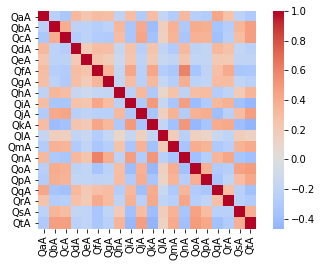

In [139]:
correlations=eda_train[Answers].corr(method = 'spearman')
sns.heatmap(correlations, cmap = 'coolwarm', square=True, center = 0)

####(A) 상관분석 
 > spearman, pearson, kendall

 1. Method of correlation:

   * pearson : standard correlation coefficient
   * kendall : Kendall Tau correlation coefficient
   * spearman : Spearman rank correlation

 2. 상관의 정의 
  * 상관 계수는 두 변수가 함께 변화하는 경향이 있는 범위를 측정한다.
  * 이 계수는 상관 관계의 정도와 방향을 모두 설명한다.

    1) Pearson 곱적률 상관
     
     ```
     Pearson 상관은 두 계량형 변수 사이의 선형 관계를 평가합니다.
     한 변수의 변화가 다른 변수의 변화에 비례적으로 연관 있는 경우 
     선형 관계가 있다.
     ```

     2) Spearman 순위 상관

     ```
     두 계량형 변수 또는 순서형 변수 사이의 단순관계를 평가한다.
     단순 관계에서 두 변수는 함께 변화하는 경향이 있지만
     반드시 일정한 비율로 변화하는 것은 아니다.

     Spearman 상관 계수는 원시 데이터가 아니라 각 변수에 대해 순위를 매긴 값을 
     기반으로 한다
     ```


     (참조)https://support.minitab.com/ko-kr/minitab/18/help-and-how-to/statistics/basic-statistics/supporting-topics/correlation-and-covariance/a-comparison-of-the-pearson-and-spearman-correlation-methods/

In [140]:
for col in eda_train[Answers]:
    print(sorted(eda_train[col].unique()))

[1.0, 2.0, 3.0, 4.0, 5.0]
[1.0, 2.0, 3.0, 4.0, 5.0]
[1.0, 2.0, 3.0, 4.0, 5.0]
[1.0, 2.0, 3.0, 4.0, 5.0]
[1.0, 2.0, 3.0, 4.0, 5.0]
[1.0, 2.0, 3.0, 4.0, 5.0]
[1.0, 2.0, 3.0, 4.0, 5.0]
[1.0, 2.0, 3.0, 4.0, 5.0]
[1.0, 2.0, 3.0, 4.0, 5.0]
[1.0, 2.0, 3.0, 4.0, 5.0]
[1.0, 2.0, 3.0, 4.0, 5.0]
[1.0, 2.0, 3.0, 4.0, 5.0]
[1.0, 2.0, 3.0, 4.0, 5.0]
[1.0, 2.0, 3.0, 4.0, 5.0]
[1.0, 2.0, 3.0, 4.0, 5.0]
[1.0, 2.0, 3.0, 4.0, 5.0]
[1.0, 2.0, 3.0, 4.0, 5.0]
[1.0, 2.0, 3.0, 4.0, 5.0]
[1.0, 2.0, 3.0, 4.0, 5.0]
[1.0, 2.0, 3.0, 4.0, 5.0]


In [141]:
flipping_columns = ["QeA", "QfA", "QkA", "QqA", "QrA"]
for flip in flipping_columns: 
    eda_train[flip] = 6 - eda_train[flip]

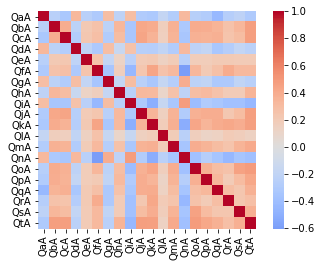

In [142]:
correlations = eda_train[Answers].corr(method = 'spearman')
sns.heatmap(correlations, cmap = 'coolwarm', square = True, center = 0)

#### (B)EDA BASELINE
 * correlation을 통한 마키아벨리즘 테스트 EDA 진행


In [143]:
questions = [i for i in list(ascii_lowercase)[:20]]
eda_train['delay'] = eda_train[[('Q'+i+'E') for i in questions]].sum(axis = 1)

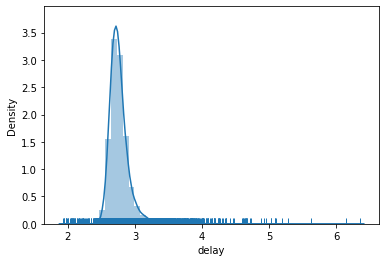

In [144]:
# delay column 분포를 고르게 하기 위해 10승 루트를 해준다.
eda_train['delay']=eda_train['delay']**(1/10)
sns.distplot(eda_train['delay'], rug = True) # rug : 데이터 위치 나타내는 선분 / kde : 밀집도 그래프(ex:kde = True)

#### (C) 그 외 변수

In [145]:
# voted = eda_train[eda_train['voted']==1]
# unvoted = eda_train[eda_train['voted']==2]

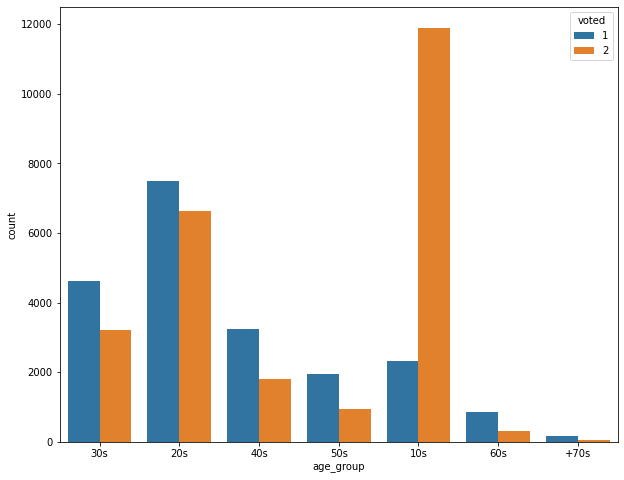

In [146]:
## 연령대별 투표 여부 합계
plt.figure(figsize=(10,8))
sns.countplot(data = eda_train, x='age_group', hue = eda_train['voted'])

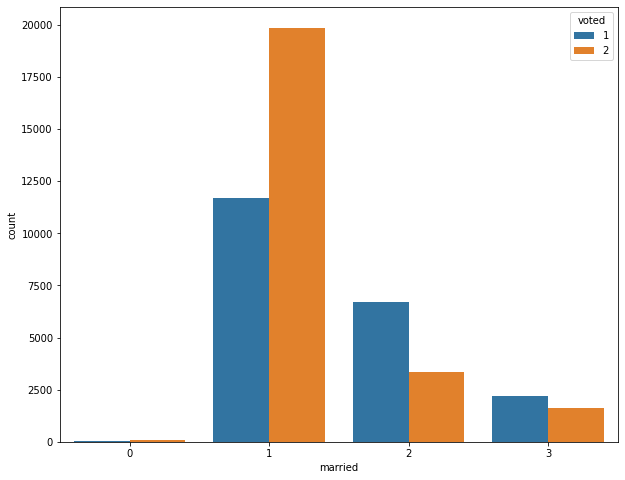

In [147]:
# 결혼 여부에 따른 투표 여부 합계
plt.figure(figsize = (10,8))
sns.countplot(data = eda_train, x='married', hue = eda_train['voted'])

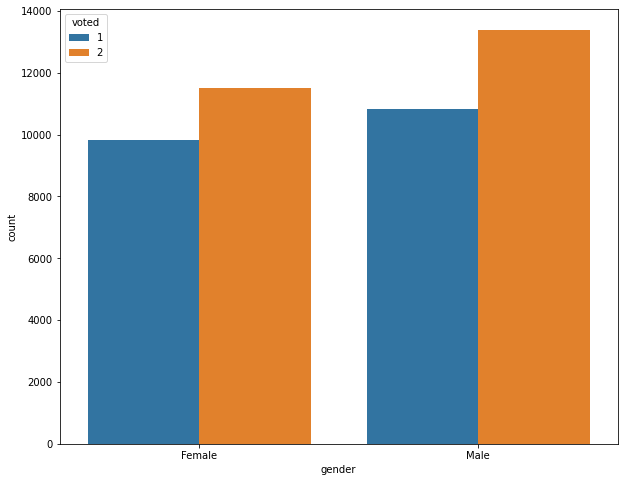

In [148]:
# 성별에 따른 투표여부 합계
plt.figure(figsize = (10,8))
sns.countplot(data = eda_train, x='gender', hue = eda_train['voted'])

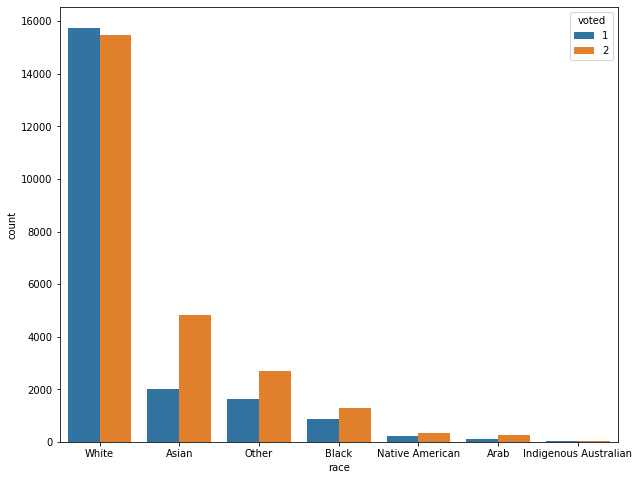

In [149]:
## 인종별 투표 여부 합계
plt.figure(figsize=(10,8))
sns.countplot(data = eda_train, x='race', hue = eda_train['voted'])

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text major ticklabel objects>)

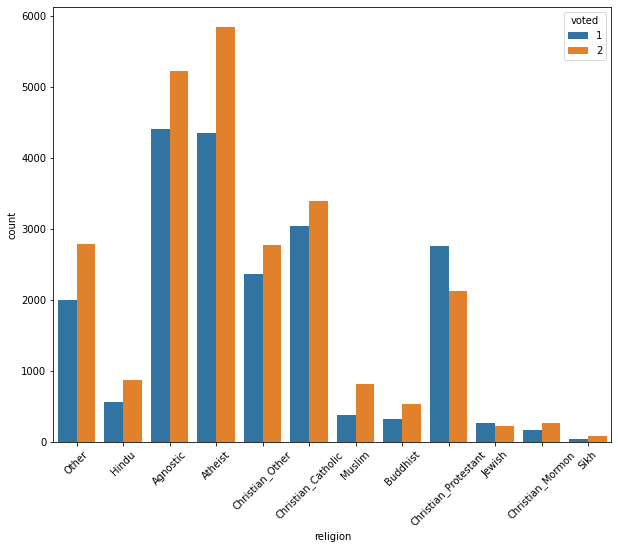

In [150]:
## 종교별 투표 여부 합계
plt.figure(figsize=(10,8))
sns.countplot(data = eda_train, x='religion', hue = eda_train['voted'])
plt.xticks(rotation=45)

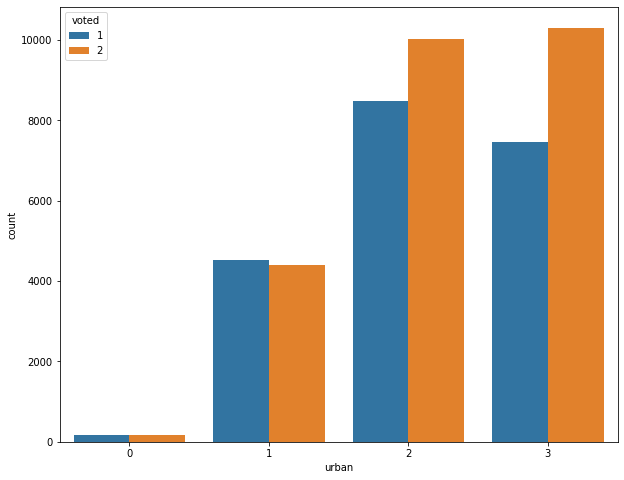

In [151]:
## 도시별 투표 여부 합계
plt.figure(figsize=(10,8))
sns.countplot(data = eda_train, x='urban', hue = eda_train['voted'])

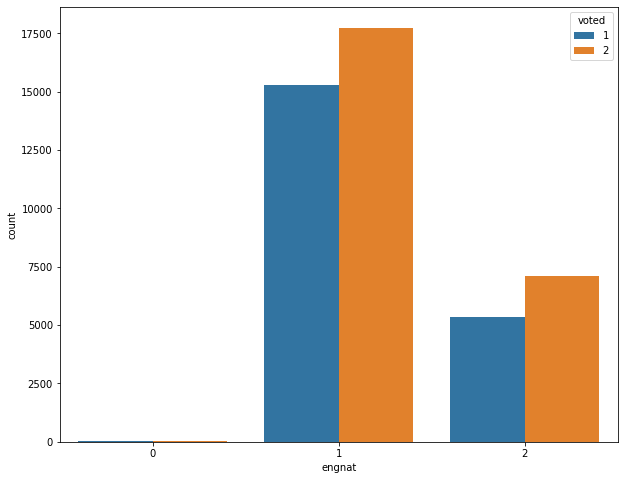

In [152]:
## 모국어가 영어인 경우의 투표 여부 합계
plt.figure(figsize=(10,8))
sns.countplot(data = eda_train, x='engnat', hue = eda_train['voted'])

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26]),
 <a list of 27 Text major ticklabel objects>)

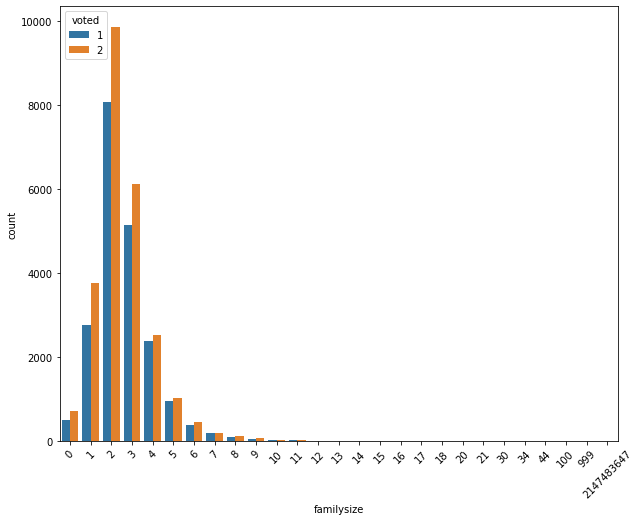

In [153]:
## 가족 형태별 투표 여부 합계
plt.figure(figsize=(10,8))
sns.countplot(data = eda_train, x='familysize', hue = eda_train['voted'])
plt.xticks(rotation=45)

## 4) Feature Engineering

In [154]:
x_train = train.copy()
x_train.drop('voted', axis=1, inplace = True)
y_train = train['voted']

In [155]:
dataset = [x_train, test]

#### 4-1. 마키아밸리 테스트

In [156]:
questions = [i for i in list(ascii_lowercase)[:20]]
answers = [('Q'+i+'A') for i in questions]

In [157]:
for data in dataset:
  data['T'] = data['QcA'] - data['QfA'] + data['QoA'] - data['QrA'] + data['QsA']
  data['V'] = data['QbA'] - data['QeA'] + data['QhA'] + data['QjA'] + data['QmA'] - data['QqA']
  data['M'] = - data['QkA']

In [158]:
flipping_columns = ["QeA", "QfA", "QkA", "QqA", "QrA"]
for data in dataset:
  for flip in flipping_columns: 
    data[flip] = 6 - data[flip]

In [159]:
flipping_secret_columns = ["QaA", "QdA", "QgA", "QiA", "QnA"]
for data in dataset:
  for flip in flipping_secret_columns: 
    data[flip] = 6 - data[flip]

In [160]:
for data in dataset:
  data['Mach_score'] = data[answers].mean(axis = 1)

In [161]:
for data in dataset:
  data['delay'] = data[[('Q'+i+'E') for i in questions]].sum(axis=1)
  data['delay'] = data['delay'] ** (1/10)

In [162]:
Ancoms = list(combinations(answers, 2))
for data in dataset:
    for a,b in Ancoms:
        data['%s_dv_%s'%(a,b)] = data[a]/data[b]

In [163]:
for data in dataset:
    data.drop([('Q'+i+'A') for i in questions], axis = 1, inplace =True)
    data.drop([('Q'+i+'E') for i in questions], axis = 1, inplace =True)

### 4-2. 그 외 변수
 * EDA에서 결과에 큰 영향이 없는 변수는 제거

In [164]:
for data in dataset:
    data.drop('hand', axis = 1, inplace = True)

In [165]:
wr_list = [('wr_0'+str(i)) for i in range(1,10)]
wr_list.extend([('wr_'+str(i)) for i in range(10,14)])
wr_no_need=[i for i in wr_list if i not in ['wr_01', 'wr_03', 'wr_06', 'wr_09', 'wr_11']]

In [166]:
for data in dataset:
    data.drop(wr_no_need, axis = 1, inplace = True)

In [167]:
# TIPT test에 따라 feature 분류
for data in dataset:
    data['Ex'] = data['tp01']-data['tp06']
    data['Ag'] = data['tp07']-data['tp02']
    data['Con'] = data['tp03']-data['tp08']
    data['Es'] =data['tp09']-data['tp04']
    data['Op'] =data['tp05']-data['tp10']

In [168]:
for data in dataset:
    # data.drop([('tp0'+str(i)) for i in range(1,10)], axis=1, inplace = True)
    data.drop([('tp0'+str(i)) for i in range(1,10)], axis=1, inplace = True)
    data.drop('tp10', axis=1, inplace = True)

In [169]:
index = test['index']
for data in dataset:
  data.drop('index', axis = 1, inplace = True)

In [170]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
needco = ['age_group','gender', 'race','religion']
for i in needco:
    x_train[i] = encoder.fit_transform(x_train[i])
    test[i] = encoder.transform(test[i])

## 5) Model

In [171]:
k_fold = KFold(n_splits = 3, shuffle = True, random_state=0)

In [172]:
clf1 = RandomForestClassifier(n_estimators=500)  # n_estimator, 생성할 tree의 갯수 / max_features, 최대 선택할 특성의 수.
clf2 = LGBMClassifier()
clf3 = GradientBoostingClassifier()
soft_vote = VotingClassifier([('r1',clf1),('r2',clf2),('r3', clf3)], voting = 'soft')  # VotingClassifier, 다수결 분류
soft_vote.fit(x_train, y_train)

VotingClassifier(estimators=[('r1',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                                     criterion='gini',
                                                     max_depth=None,
                                                     max_features='auto',
                                                     max_leaf_nodes=None,
                                                     max_samples=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
        

#### 5-1. VotingClassifier
>  다수결 분류

 1. Hard Voting Classifier
    ```
    여러 모델을 생성하고 결과를 비교한다. 
    이때 classifier의 결과들을 집계해 가장 많은 표를 얻는 클래스를
    최종 예측값으로 정한다.
    ```

 2. Soft Voting Classifier (__가중치 투표__)
    ```
    앙상블에 사용되는 모든 분류기가 클래스의 확률을 예측할 수 있을 때 사용한다.
    각 분류기의 예측의 평균을 내 확률이 가장 높은 클래스로 예측하게 된다
    ```


In [173]:
model = soft_vote
model.predict_proba(test)
pred_y = model.predict_proba(test)
pred_y[:,1]
pred_y = pred_y[:,1]

submission = pd.DataFrame({'index':index, 'voted':pred_y})
submission.to_csv('../model1.csv', index=False)

# [Model2] Lgbm Ensemble with different features

## 1) Libraries

In [174]:
pip install eli5 # 변수 중요성을 알려주는 패키지 PermutationImportance

In [175]:
import pandas as pd
import numpy as np

from string import ascii_lowercase
from itertools import combinations

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score

In [176]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestRegressor
import eli5
from eli5.sklearn import PermutationImportance

import matplotlib.pyplot as plt

import warnings
import gc
warnings.filterwarnings('ignore')

## 2) Data Load

In [177]:
train = pd.read_csv('/content/drive/MyDrive/dacon/심리성향 예측/train.csv')
test = pd.read_csv('/content/drive/MyDrive/dacon/심리성향 예측/test_x.csv')

## 3) Feature Engineering

In [178]:
x_train = train.copy()
x_train.drop('voted', axis =1, inplace = True)
y_train = train['voted']

In [179]:
dataset = [x_train, test]

### 3-1. 마키아벨리 테스트 FE

In [180]:
questions = [i for i in list(ascii_lowercase)[:20]]
answer = [('Q'+i+'A') for i in questions]

In [181]:
for data in dataset:
  data['T'] = data['QcA'] - data['QfA'] + data['QoA'] - data['QrA'] + data['QsA']
  data['V'] = data['QbA'] - data['QeA'] + data['QhA'] + data['QjA'] + data['QmA'] - data['QqA']
  data['M'] = - data['QkA']

In [182]:
flipping_columns = ["QeA", "QfA", "QkA", "QqA", "QrA"]
for data in dataset:
  for flip in flipping_columns: 
    data[flip] = 6 - data[flip]

In [183]:
flipping_secret_columns = ["QaA", "QdA", "QgA", "QiA", "QnA"]
for data in dataset:
  for flip in flipping_secret_columns: 
    data[flip] = 6 - data[flip]

In [184]:
for data in dataset:
  data['Mach_score'] = data[answers].mean(axis = 1)

In [185]:
for data in dataset:
  data['delay'] = data[[('Q'+i+'E') for i in questions]].sum(axis=1)
  data['delay'] = data['delay'] ** (1/10)
  data['delay_var'] = data['delay'].var()

In [186]:
Ancoms = list(combinations(answers, 2))
for data in dataset:
  for a,b in Ancoms:
    data['mach_%s_dv_%s'%(a,b)] = data[a]/data[b]

In [187]:
for data in dataset:
  data['mach_var'] = data[answers].var(axis=1)

### 3-2. 그 외 변수

In [188]:
# TIPI features 일반적인 형태로 변환
tps = ['tp01', 'tp02', 'tp03', 'tp04', 'tp05', 'tp06', 'tp07', 'tp08', 'tp09', 'tp10']
for data in dataset:
  for tp in tps:
    data[tp] = 7 - data[tp]

In [189]:
# tp중 무응답 값은 평균값으로 대체
for data in dataset:
    for tp  in tps:
        data[tp] = data[tp].replace(0, np.nan)
        mean = data[tp].mean(axis=0)
        data[tp] = data[tp].replace(np.nan, mean)

In [190]:
for data in dataset:
  data['Ex'] = data['tp01']-data['tp06']
  data['Ag'] = data['tp07']-data['tp02']
  data['Con'] = data['tp03']-data['tp08']
  data['Es'] =data['tp09']-data['tp04']
  data['Op'] =data['tp05']-data['tp10']

In [191]:
index = test['index']
for data in dataset:
    data.drop('index', axis=1,inplace=True)

In [192]:
# 10대 여부 컬럼 생성
for data in dataset:
    teenager_ox = 1*np.array(data['age_group']=='10s')
    data['teenager_ox'] = teenager_ox

In [193]:
tpcoms = list(combinations(tps,2))
for data in dataset:
    for a,b in tpcoms:
         data['tp_%s_dv_%s'%(a,b)] = data[a]/data[b]

In [194]:
# tp 값들끼리 나눈 feature 생성
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
needco = ['age_group','gender','race','religion']
for i in needco:
    x_train[i] = encoder.fit_transform(x_train[i])
    test[i] = encoder.transform(test[i])

In [ ]:
# EDA 결과, 성별에 따라 Emotional Stability/ Conscience/ Open Minded가 투표 여부에 미치는 영향이 크다고 판단되어 feature를 추가
for data in dataset:
    data['Es_gender'] = data['Es']*data['gender']
    data['Con_gender'] = data['Con']*data['gender']
    data['Op_gender'] = data['Op']*data['gender']

## 4) Feature Selection 1 & Model 2-1
 * random_state=4040

In [ ]:
def lgbm_rfe_4040(x_data, y_data, ratio = 0.9, min_feats = 40):
    feats = x_data.columns.tolist()
    archive = pd.DataFrame(columns = ['model','n_feats', 'feats', 'score'])
    while True:
        model = LGBMClassifier(objective='binary', num_iterations=10**4)
        x_train, x_val, y_train, y_val = train_test_split(x_data[feats], y_data, random_state=4040)
        model.fit(x_train, y_train, eval_set=[(x_val, y_val)], early_stopping_rounds=100, verbose=False)
        
        val_pred = model.predict_proba(x_val)
        val_pred=val_pred[:,1]
        
        score = roc_auc_score(y_val, val_pred)
        
        n_feats = len(feats)
        print(n_feats,score)
        
        archive = archive.append({'model': model, 'n_feats': n_feats, 'feats': feats, 'score': score}, ignore_index=True)
        feat_imp = pd.Series(model.feature_importances_, index=feats).sort_values(ascending=False)
        next_n_feats = int(n_feats * ratio)
        
        if next_n_feats < min_feats:
            break
        else:
            feats = feat_imp.iloc[:next_n_feats].index.tolist()
    return archive



In [ ]:
lgbm_archive_4040 = lgbm_rfe_4040(x_train, y_train)

In [ ]:
model = LGBMClassifier(objective='binary', num_iterations = 10**3)

x_train_1 = x_train[lgbm_archive_4040.iloc[7,2]]

model.fit(x_train_1,y_train)

pred_y1 = model.predict_proba(test[lgbm_archive_4040.iloc[7,2]])
pred_y1 = pred_y1[:,1]


## 5) Feature Selection2 & Model 2-2
 * random_state=1234

 

In [ ]:
def lgbm_rfe_1234(x_data, y_data, ratio = 0.9, min_feats=40):
    feats = x_data.columns.tolist()
    archive = pd.DataFrame(columns=['model','n_feats','feats','score'])
    while True:
        model = LGBMClassifier(objective='binary', num_iterations=10**4)
        x_train,x_val,y_train,y_val = train_test_split(x_data[feats], y_data, random_state=1234)
        
        model.fit(x_train, y_train, eval_set=[(x_val, y_val)], early_stopping_rounds=100, verbose=False)

        val_pred = model.predict_proba(x_val)
        val_pred = val_pred[:,1]

        score=roc_auc_score(y_val, val_pred)
        n_feats=len(feats)
        print(n_feats, score)
        
        archive=archive.append({'model':model, 'n_feats':n_feats, 'feats':feats,'score':score}, ignore_index=True)
        feat_imp = pd.Series(model.feature_importances_, index=feats).sort_values(ascending=False)
        next_n_feats = int(n_feats*ratio)

        if next_n_feats < min_feats:
            break
        else:
            feats = feat_imp.iloc[:next_n_feats].index.tolist()
    
    return archive


In [ ]:
lgbm_archive_1234 = lgbm_rfe_1234(x_train, y_train)

In [ ]:
model2 = LGBMClassifier(objective='binary', num_iterations=10**3)

x_train2 = x_train[lgbm_archive_1234.iloc[14,2]]

model2.fit(x_train2, y_train)

pred_y2 = model2.predict_proba(test[lgbm_archive_1234.iloc[14,2]])
pred_y2 = pred_y2[:,1]

## 6) Feature Selection3 & Model 2-3
 * random_state=99087

In [ ]:
def lgbm_rfe_99087(x_data, y_data, ratio=0.9, min_feats=40):
    feats = x_data.columns.tolist()
    archive = pd.DataFrame(columns=['model', 'n_feats', 'feats', 'score'])
    while True:
        model = LGBMClassifier(objective = 'binary', num_iterations=10**4)
        x_train, x_val, y_train, y_val = train_test_split(x_data[feats], y_data, random_state=99087)
        model.fit(x_train, y_train, eval_set=[(x_val, y_val)], early_stopping_rounds=100, verbose=False)
        val_pred = model.predict_proba(x_val)
        val_pred = val_pred[:,1]
        score = roc_auc_score(y_val, val_pred)
        n_feats = len(feats)
        print(n_feats, score)
        archive = archive.append({'model': model, 'n_feats': n_feats, 'feats': feats, 'score': score}, ignore_index=True)
        feat_imp = pd.Series(model.feature_importances_, index=feats).sort_values(ascending=False)
        next_n_feats = int(n_feats * ratio)
        if next_n_feats < min_feats:
            break
        else:
            feats = feat_imp.iloc[:next_n_feats].index.tolist()
    return archive

In [ ]:
lgbm_archive_99087 = lgbm_rfe_99087(x_train, y_train)

In [ ]:
model3 = LGBMClassifier(objective="binary", num_iterations= 10**3)

x_train_3 = x_train[lgbm_archive_99087.iloc[7,2]]

model3.fit(x_train_3, y_train)

pred_y3 = model3.predict_proba(test[lgbm_archive_99087.iloc[7,2]])
pred_y3 = pred_y3[:,1]

## 7) Feature Selection4 & Model 2-4
* random_state = 42

In [ ]:
def lgbm_rfe_42(x_data, y_data, ratio=0.9, min_feats=40):
    feats = x_data.columns.tolist()
    archive = pd.DataFrame(columns=['model', 'n_feats', 'feats', 'score'])
    while True:
        model = LGBMClassifier(objective = 'binary', num_iterations=10**4)
        x_train, x_val, y_train, y_val = train_test_split(x_data[feats], y_data, random_state=42)
        model.fit(x_train, y_train, eval_set=[(x_val, y_val)], early_stopping_rounds=100, verbose=False)
        val_pred = model.predict_proba(x_val)
        val_pred = val_pred[:,1]
        score = roc_auc_score(y_val, val_pred)
        n_feats = len(feats)
        print(n_feats, score)
        archive = archive.append({'model': model, 'n_feats': n_feats, 'feats': feats, 'score': score}, ignore_index=True)
        feat_imp = pd.Series(model.feature_importances_, index=feats).sort_values(ascending=False)
        next_n_feats = int(n_feats * ratio)
        if next_n_feats < min_feats:
            break
        else:
            feats = feat_imp.iloc[:next_n_feats].index.tolist()
    return archive

In [ ]:
lgbm_archive_42 = lgbm_rfe_42(x_train, y_train)

In [ ]:
model4 = LGBMClassifier(objective="binary", num_iterations= 10**3)

x_train_4 = x_train[lgbm_archive_42.iloc[8,2]]

model4.fit(x_train_4, y_train)

pred_y4 = model4.predict_proba(test[lgbm_archive_42.iloc[8,2]])
pred_y4 = pred_y4[:,1]

## 8) Ensemble

In [ ]:
pred_all=(pred_y+pred_y2+pred_y3+pred_y4) * (1/4)

submission = pd.DataFrame({'index':index, 'voted':pred_all})
submission.to_csv('./model2.csv',index=False)

# [Model3] : Neural Network
 [학습]
  1. K -FOLD Cross Validation을 적용(10 Fold(s))
  2. 두 개의 hidden layer을 갖는 간단한 신경망 모델 사용
  3. 모델의 크기와 (미니)배치 크기, lr, weight_decay 등의 하이퍼파라미터는 optuna를 이용해 최적화한 값.
  4. 전체 K-Fold Cross VAlidation의 과정 5번 반복.
  5. Binary Cross Entropy를 loss 함수로 사용하고, label의 True/False 불균형을 해결하기 위해 True 인 경우 약 1.2의 가중치 부여
  6. 최종 결과는 확률 값을 산술 평균한 결과.

## 1) Libraries

In [ ]:
import random
from datetime import datetime 

import numpy as np
import pandas as pd

import torch
from sklearn.model_selection import StratifiedKFold
from torch import nn,optim
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from tqdm import tqdm  # 진행표시바


### 1-1. Libraries 설명
 
  # torch
  
  ```
  PyTorch
   * Numpy와 유사하지만 GPU상에서 실행 가능한 N차원 Tensor
   * 신경망을 구성하고 학습하는 과정에서의 자동 미분

   신경망을 생성하고학습시키는 것을 도와주기 위해 nn, optim, Dataset, DataLoader
   와 같은 디자인된 모듈과 클래스들을 제공한다.

   (참조,'예제로 배우는 PyTorch') https://tutorials.pytorch.kr/beginner/deep_learning_60min_blitz.html
  ```
 

  + NN
  ```
    * nn.Module, 모든 신경망 모듈의 기본이 되는 클래스
    * 각 층과 함수 등 신경망의 구성요호를 이 클래스 안에서 정의한다.
    * nn.Module은 모든 신경망 모듈의 기본이 되는 클래스로 레이어, 함수 등을 정의한다.
    * 신경망은 torch.nn 패키지를 사용해 생성할 수 있다.

    (참조,Neural Network 구현하기) https://deepinsight.tistory.com/86
  ```


  + optim
 ```
 * 딥러닝에 사용하는 SGD+momentum, RMSProp, Adam 등과 같은 최적화 알고리즘 지원.

 (참조,PYTORCH:OPTIM) https://tutorials.pytorch.kr/beginner/examples_nn/two_layer_net_optim.html
 ```

  + DataLoader
  ```
 * 방대한 데이터를 미니배치 단위로 처리할 수 있고, 
   데이터를 무작위섞으며 학습의 효율성을 향상시킬 수 있다.

 (참조, 머신러닝 튜토리얼 강의 8)https://wingnim.tistory.com/33
 (참조, DataLoader Paramter별 용도 )https://subinium.github.io/pytorch-dataloader/
  ```




In [ ]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.backends.cudnn.deterministic=True
torch.backends.cudnn.benchark = False

### 1-2. Libraries 설명2
 * CuDNN
  ```
  random seed를 torch와 numpy만 고정하고 사용시 재현 불가할 수 있다.
  이럴 때 재현을 위해 사용하는 라이브러리
  * Randomness 제어를 위한 설정법은 4,5번 줄처럼 설정
  ```


In [ ]:
## pythorch GPU Check
# torch.cuda.is_available(), cuda가 사용 가능한지 확인
# (참조, pytorch GPU check) https://aigong.tistory.com/46
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu' 

In [ ]:
drop_list = ['QaE', 'QbE', 'QcE', 'QdE', 'QeE',
             'QfE', 'QgE', 'QhE', 'QiE', 'QjE',
             'QkE', 'QlE', 'QmE', 'QnE', 'QoE',
             'QpE', 'QqE', 'QrE', 'QsE', 'QtE',
             'index', 'hand']

In [ ]:
replace_dict = {'education': str, 'engnat': str, 'married': str, 'urban': str}

In [ ]:
train_data = pd.read_csv('/content/drive/MyDrive/dacon/심리성향 예측/train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/dacon/심리성향 예측/test_x.csv')

In [ ]:
# familysize 이상치 제거
train_data=train_data.drop(train_data[train_data.familysize>50].index)

In [ ]:
train_y = train_data['voted']
train_x=train_data.drop(drop_list+['voted'], axis=1)
test_x = test_data.drop(drop_list, axis=1)

In [ ]:
train_x=train_x.astype(replace_dict)
test_x = test_x.astype(replace_dict)

In [ ]:
train_x = pd.get_dummies(train_x)
test_x = pd.get_dummies(test_x)

In [ ]:
train_y = 2 - train_y.to_numpy()
train_x = train_x.to_numpy()
test_x = test_x.to_numpy()

In [ ]:
train_y_t = torch.tensor(train_y, dtype=torch.float32)
train_x_t = torch.tensor(train_x, dtype=torch.float32)
test_x_t = torch.tensor(test_x, dtype=torch.float32)

In [ ]:
train_x_t[:,:20] = (train_x_t[:,:20]-3)/2.
test_x_t[:,:20] = (test_x_t[:,:20]-3)/2.

train_x_t[:, 20] = (train_x_t[:, 20] - 5.) / 4.
test_x_t[:, 20] = (test_x_t[:, 20] - 5.) / 4.

train_x_t[:,21:31] = (train_x_t[:,21:31] - 3.5)/3.5
test_x_t[:,21:31] = (test_x_t[:,21:31] - 3.5)/3.5

test_len = len(test_x_t)

In [ ]:
N_REPEAT=5
N_SKFOLD=7
N_EPOCH=48
BATCH_SIZE=72
LOADER_PARAM = {
                'batch_size':BATCH_SIZE,
                'num_workers':4,
                'pin_memory':True
                }
prediction = np.zeros((test_len,1), dtype=np.float32)

In [ ]:
for repeat in range(N_REPEAT):

    skf, tot = StratifiedKFold(n_splits=N_SKFOLD, random_state=repeat, shuffle=True), 0.
    for skfold, (train_idx, valid_idx) in enumerate(skf.split(train_x, train_y)):
        
        train_idx, vaild_idx = list(train_idx), list(valid_idx)
        
        train_loader = DataLoader(TensorDataset(train_x_t[train_idx,:], train_y_t[train_idx]), shuffle=True, drop_last=True, **LOADER_PARAM)
        valid_loader = DataLoader(TensorDataset(train_x_t[valid_idx,:], train_y_t[valid_idx]), shuffle=False, drop_last=False, **LOADER_PARAM)
        test_loader = DataLoader(TensorDataset(test_x_t, torch.zeros((test_len), dtype=torch.float32)), shuffle = False, drop_last=False, **LOADER_PARAM)

        model = nn.Sequential(
            nn.Dropout(0.05),
            nn.Linear(91, 180, bias = False),
            nn.LeakyReLU(0.05, inplace = True),
            nn.Dropout(0.5),
            nn.Linear(180,32,bias=32),
            nn.ReLU(inplace = True),
            nn.Linear(32,1)
        ).to(DEVICE)

        criterion = torch.nn.BCEWithLogitsLoss(pos_weight = torch.tensor([1.20665], device = DEVICE))
        optimizer = optim.AdamW(model.parameters(), lr=5e-3, weight_decay = 7.8e-2)
        scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimzier, T_0=N_EPOCH // 6, eta_min=4e-4)
        prediction_t, loss_t = np.zeros((test_len,1), dtype=np.float32), 1.
        
        # for epoch in range(N_EPOCH)
        for epoch in tqdm(range(N_EPOCH), desc='{:02d}/{:02d}'.format(skfold + 1, N_SKFOLD)):
            model.train()
            for idx, (xx, yy) in enumerate(train_loader):
                optimizer.zero_grad()
                xx,yy = xx.to(DEVICE), yy.to(DEVICE)
                pred = model(xx).squeeze()
                loss = criterion(pred, yy)
                loss.backward()
                optimizer.step()
                scheduler.step(epoch + idx / len(train_loader))

            with torch.no_grad():
                model.eval()
                running_acc, running_loss, running_count = 0,0.,0
                for xx, yy in valid_loader:
                    xx, yy = xx.to(DEVICE), yy.to(DEVICE)
                    pred = model(xx).squeeze()
                    loss = criterion(pred, yy)
                    running_loss += loss.item() * len(yy)
                    running_count += len(yy)
                    running_acc += ((torch.sigmoid(pred)>0.5).float() == yy).sum().item()
                    
            if running_acc/running_loss < loss_t:
                loss_t = running_loss / running_count
                for idx, (xx, _) in enumerate(test_loader):
                    xx = xx.to(DEVICE)
                    pred = (2. - torch.sigmoid(model(xx).detach().to('cpu'))).numpy()
                    prediction_t[BATCH_SIZE * idx:min(BATCH_SIZE*(idx+1), len(prediction)),:] = pred[:,:].copy()
            prediction[:, :] += prediction_t[:, :].copy() / (N_REPEAT * N_SKFOLD)
        tot += loss_t
    print('R{} -> {:6.4f}'.format(repeat + 1, tot/N_SKFOLD))


df = pd.read_csv('/content/drive/MyDrive/dacon/심리성향 예측.sample_submission.csv')
df.iloc[:,1:] = prediction


In [ ]:
## 복붙(test)

N_REPEAT = 5
N_SKFOLD = 7
N_EPOCH = 48
BATCH_SIZE = 72
LOADER_PARAM = {
    'batch_size': BATCH_SIZE,
    'num_workers': 4,
    'pin_memory': True
}
prediction = np.zeros((test_len, 1), dtype=np.float32)

for repeat in range(N_REPEAT):

    skf, tot = StratifiedKFold(n_splits=N_SKFOLD, random_state=repeat, shuffle=True), 0.
    for skfold, (train_idx, valid_idx) in enumerate(skf.split(train_x, train_y)):
        train_idx, valid_idx = list(train_idx), list(valid_idx)
        train_loader = DataLoader(TensorDataset(train_x_t[train_idx, :], train_y_t[train_idx]),
                                  shuffle=True, drop_last=True, **LOADER_PARAM)
        valid_loader = DataLoader(TensorDataset(train_x_t[valid_idx, :], train_y_t[valid_idx]),
                                  shuffle=False, drop_last=False, **LOADER_PARAM)
        test_loader = DataLoader(TensorDataset(test_x_t, torch.zeros((test_len,), dtype=torch.float32)),
                                 shuffle=False, drop_last=False, **LOADER_PARAM)
        model = nn.Sequential(
            nn.Dropout(0.05),
            nn.Linear(91, 180, bias=False),
            nn.LeakyReLU(0.05, inplace=True),
            nn.Dropout(0.5),
            nn.Linear(180, 32, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(32, 1)
        ).to(DEVICE)
        criterion = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor([1.20665], device=DEVICE))
        optimizer = optim.AdamW(model.parameters(), lr=5e-3, weight_decay=7.8e-2)
        scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
            optimizer, T_0=N_EPOCH // 6, eta_min=4e-4)
        prediction_t, loss_t = np.zeros((test_len, 1), dtype=np.float32), 1.

        # for epoch in range(N_EPOCH):
        for epoch in tqdm(range(N_EPOCH), desc='{:02d}/{:02d}'.format(skfold + 1, N_SKFOLD)):
            model.train()
            for idx, (xx, yy) in enumerate(train_loader):
                optimizer.zero_grad()
                xx, yy = xx.to(DEVICE), yy.to(DEVICE)
                pred = model(xx).squeeze()
                loss = criterion(pred, yy)
                loss.backward()
                optimizer.step()
                scheduler.step(epoch + idx / len(train_loader))

            with torch.no_grad():
                model.eval()
                running_acc, running_loss, running_count = 0, 0., 0
                for xx, yy in valid_loader:
                    xx, yy = xx.to(DEVICE), yy.to(DEVICE)
                    pred = model(xx).squeeze()
                    loss = criterion(pred, yy)
                    running_loss += loss.item() * len(yy)
                    running_count += len(yy)
                    running_acc += ((torch.sigmoid(pred) > 0.5).float() == yy).sum().item()
                # print('R{:02d} S{:02d} E{:02d} | {:6.4f}, {:5.2f}%'
                #       .format(repeat + 1, skfold + 1, epoch + 1, running_loss / running_count,
                #               running_acc / running_count * 100))

                if running_loss / running_count < loss_t:
                    loss_t = running_loss / running_count
                    for idx, (xx, _) in enumerate(test_loader):
                        xx = xx.to(DEVICE)
                        pred = (2. - torch.sigmoid(model(xx).detach().to('cpu'))).numpy()
                        prediction_t[BATCH_SIZE * idx:min(BATCH_SIZE * (idx + 1), len(prediction)), :] \
                            = pred[:, :].copy()
        prediction[:, :] += prediction_t[:, :].copy() / (N_REPEAT * N_SKFOLD)
        tot += loss_t
    print('R{} -> {:6.4f}'.format(repeat + 1, tot / N_SKFOLD))

df = pd.read_csv('/content/drive/MyDrive/dacon/심리성향 예측/sample_submission.csv')
df.iloc[:, 1:] = prediction

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/dacon/심리성향 예측/sample_submission.csv')
df.iloc[:, 1:] = prediction

In [ ]:
df.to_csv('/content/drive/MyDrive/dacon/심리성향 예측/model3.csv', index=False)

### 1-3. nn.Sequential 변수
1. 입력값이 하나일 때, 각 레이러를 데이터가 순차적으로 지나갈 때 사용하면 좋은 방법
2. 여러 nn.Module을 한 컨테이너에 넣고 돌리는 방법.
 
 # 1.nn.Dropout
   - 일부 파라미터를 학습에 반영하지 않으므로 모델을 일반화하는 방법
   - 뉴런이라 부르는 노드를 무작위로 On/Off 반복하는 것.
   - 예를 들어, 학습 데이터 x가 주어졌을 때, 각 레이어별로 x데이터의 사용 여부를 결정하는 것이다.
    - (주의) Train시에는 Dropout을 적용해야 하지만, Validation, Test에는 적용금지.
    - (참고)https://eda-ai-lab.tistory.com/405
   ```
   1) overfitting 방지
   2) 성능 향상
   3) 매번 다른 형태의 노드로 학습하기 때문에, 여러 형태 네트워크들을 통해 앙상블 효과를 낼 수 있다.
   ```

 # 2. nn.Linear
   nn.Linear(input_dim, output_dim)
   1. 입력 차원, 출력 차원을 인수로 받는다
 
 # 3. nn.LeakyReLU
  1. ReLU를 보완하기 위해 ReLU의 변형 함수들이 등장.
  2. LeakyReLU는 입력값이 음수일 경우 0이 아닌 0.001과 같은 매우 작은수를 반환하도록 되어있다.
   - (참조, 파이토치로 시작하는 딥러닝 입문) https://wikidocs.net/60683
   ```
   수식은 f(x) = max(ax,x)로 간단하다.
   a는 하이퍼파라미터를 Leaky('새는') 정도를 결정하며 일반적으로 0.01의 값을 갖는다. 
   여기서 말하는 '새는 정도'라는 것은 입력값이 음수일 경우의 기울기를 의마한다.
  ```

 # 4. torch.nn.BCEWithLogitsLoss
  1. 클래스가 2개인 binary case인 경유 BCELoss 사용하는 것이 좋다.
  2. (BCEWithLogitsLoss)BCELoss에 Sigmoid layer를 더한 것이다.
   - (Sigmoid + BCELoss) 따라서 따로 sigmoid나 softmax를 할 필요 없다.
   - (참조, 자주쓰는 Loss Function 정리) https://nuguziii.github.io/dev/dev-002/

 # 5. 그 외
 1. adam, https://wikidocs.net/36033
  (Adam)
  - RMSprop + Momentum
  - 방햑과 학습률 두 가지를 모두 잡기 위한 방법.
  keras.optimizers.Adam(lr , beta_1, deta_2, epsilon, decay, amsgrad=True/False)
 
 2. lr_scheduler
  - 학습률 스케쥴러 (Learning Rate Scheduler)
  - 학습을 진행하며 학습률이 상황에 맞게 변경될 수 있다면 더낮은 손실값을 얻을 수 있다.
    - (참고, 딥러닝 학습 향상을 위한 고려 사항들)http://www.gisdeveloper.co.kr/?p=8443
    
    ```
     * 학습률 스케줄러는 옵티마이져를 통해 적용된다.
     optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
 
     * 지정한 스텝 단위로 학습률에 감마를 곱해 학습룰을 감소시키는 방식
     scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[10,20,40], gamma= 0.1) 
    ```

  3. CosineAnnealingWarmRestarts
   -  learning late 조절하는데 사용

In [ ]:
df.to_csv('/content/drive/MyDrive/dacon/심리성향 예측/model3.csv', index = False)

# [Fianl Ensemble]

In [ ]:
model1 = pd.read_csv('./model1.csv', index_col = 'index')
model2 = pd.read_csv('./model2.csv', index_col = 'index')

pred_y (model1)*(0.7) + (model2)*(0.3)

test = pd.read_csv('./content/drive/MyDrive/dacon/심리성향 예측/test_x.csv')
index = test['index']

submission = pd.DataFrame({'indx' : index, 'voted' : pred_y['vpted']})

submission.to_csv('./content/drive/MyDrive/dacon/심리성향 예측/model1_mode.2.csv', index_col = False )

In [ ]:
# 모델 불러오기
combined_12 = pdread_csv('/content/drive/MyDrive/dacon/심리성향 예측/model1_model2.csv', index_col = 'index')
model3 = pd.read_csv('/content/drive/MyDrive/dacon/심리성향 예측/model3.csv', index_col='index')

model3['voted'] = model3['voted']-1
#=> 다른 모델과 같이 [0,1]의 범위(voted가 2일 확률을 맞춰주기 위해 1 빼기.)

In [ ]:
pred_y = (model3)*(0.8) + (combined_12)*(0.2)

test = pd.read_csv('/content/drive/MyDrive/dacon/심리성향 예측/test_x.csv')
index = test['index']

submission = pd.read_DataFrame({'index':index, 'voted':pred_y['voted']})
submission.to_csv('/content/drive/MyDrive/dacon/심리성향 예측/submission_final.csv',index=False)